In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [135]:
import numpy as np
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.special import expit as sigmoid
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import pandas as pd
from pathlib import Path
from time import strftime

### The Perceptron

In [3]:
iris = load_iris(as_frame=True)
X = iris.data[["sepal length (cm)", "sepal width (cm)"]].values
y = (iris.target == 0)

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

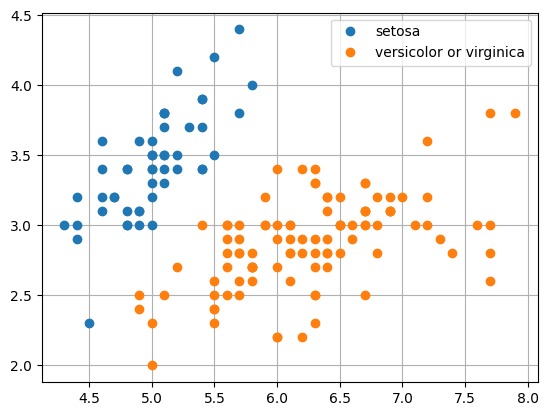

In [5]:
plt.plot(X[:, 0][y==True], X[:, 1][y==True], "o", label="setosa")
plt.plot(X[:, 0][y==False], X[:, 1][y==False], "o", label="versicolor or virginica")
plt.grid()
plt.legend()

In [6]:
scaler = StandardScaler()
per_clf = Perceptron(random_state=42)
scaled_per_clf = make_pipeline(scaler, per_clf)
scaled_per_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('perceptron', Perceptron(random_state=42))])

In [7]:
w = per_clf.coef_[0] / scaler.scale_
b = per_clf.decision_function([-scaler.mean_ / scaler.scale_])

axes = [ X[:, 0].min()-0.2, X[:, 0].max()+0.2,  X[:, 1].min()-0.2, X[:, 1].max()+0.2]
xmin, xmax = X[:, 0].min()-1, X[:, 0].max()
z = np.linspace(xmin, xmax, 500)
decision_boundary = -w[0] / w[1] * z - b / w[1]

In [8]:

from matplotlib.colors import ListedColormap
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 200).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = scaled_per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

(4.1, 8.1, 1.8, 4.6000000000000005)

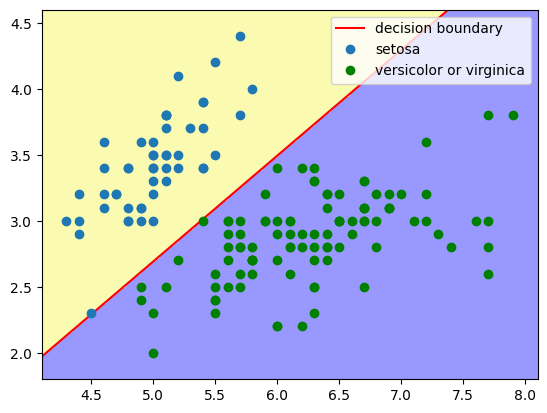

In [9]:
plt.plot(z, decision_boundary, "r-", label="decision boundary")
plt.plot(X[:, 0][y==True], X[:, 1][y==True], "o", label="setosa")
plt.plot(X[:, 0][y==False], X[:, 1][y==False], "go", label="versicolor or virginica")
plt.legend(loc="upper right")
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.axis(axes)

### Activation function

(-4.5, 4.5, -0.2, 1.2)

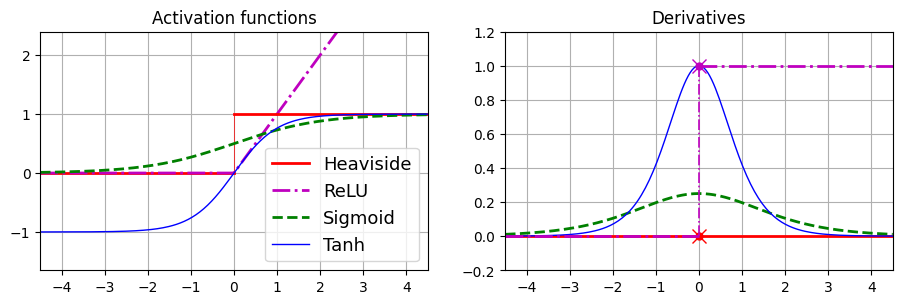

In [10]:
def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

### Regression MLPs

In [3]:
housing = fetch_california_housing()

In [4]:
list(housing)

['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR']

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
  housing.data, housing.target, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
  X_train_full, y_train_full, random_state=42
)

In [963]:
mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)

In [965]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[50, 50, 50],
                              random_state=42))])

In [983]:
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred)
np.sqrt(rmse)

np.float64(0.5053326657968437)

### Implementing MLPs with Keras

### Image Classifier

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [4]:
X_train.shape

(55000, 28, 28)

In [5]:
X_train.dtype

dtype('uint8')

In [6]:
X_train, X_valid, X_test = X_train/255., X_valid/255., X_test/255.

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
class_names[y_train[0]]

'Ankle boot'

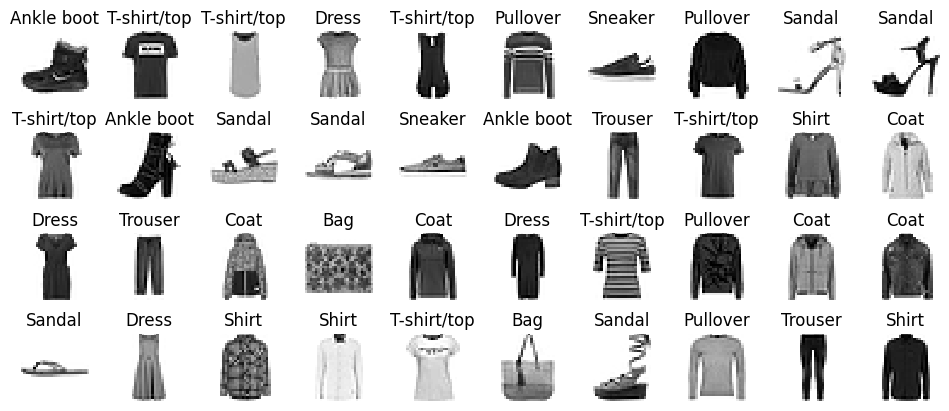

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [10]:
tf.random.set_seed(42)
model = keras.Sequential()
model.add(layers.Input(shape=[28, 28]))
model.add(layers.Flatten())
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [11]:
model = keras.Sequential([
  layers.Flatten(input_shape=[28, 28]),
  layers.Dense(300, activation="relu"),
  layers.Dense(100, activation="relu"),
  layers.Dense(10, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.layers

In [14]:
hidden1 = model.layers[2]
hidden1.name

'dense_4'

In [18]:
model.get_layer("dense_4") is hidden1

True

In [19]:
weights, biases = hidden1.get_weights()

In [20]:
weights

array([[ 0.10906368,  0.05278177, -0.08773276, ...,  0.01737181,
        -0.08813687,  0.0419871 ],
       [-0.07758407,  0.06858488,  0.02257303, ..., -0.10682523,
        -0.08446953, -0.0061474 ],
       [-0.08464348, -0.11232359, -0.00020321, ...,  0.00285586,
        -0.02608187,  0.00387607],
       ...,
       [ 0.04765936,  0.09121772,  0.01713108, ...,  0.03578011,
        -0.1211664 , -0.09497619],
       [-0.0702031 ,  0.11888426, -0.07921402, ..., -0.09505825,
         0.09319039,  0.09833463],
       [ 0.04041003,  0.0382997 ,  0.04361244, ...,  0.04905259,
        -0.07321794, -0.00035863]], dtype=float32)

In [21]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [22]:
weights.shape, biases.shape

((300, 100), (100,))

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [24]:
keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [25]:
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

In [26]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 9s 4ms/step - loss: 0.7157 - accuracy: 0.7649 - val_loss: 0.5009 - val_accuracy: 0.8282
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4869 - accuracy: 0.8301 - val_loss: 0.4681 - val_accuracy: 0.8320
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4423 - accuracy: 0.8447 - val_loss: 0.4246 - val_accuracy: 0.8516
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4178 - accuracy: 0.8533 - val_loss: 0.3994 - val_accuracy: 0.8602
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3968 - accuracy: 0.8615 - val_loss: 0.3950 - val_accuracy: 0.8602
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3802 - accuracy: 0.8656 - val_loss: 0.3934 - val_accuracy: 0.8642
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3678 - accuracy: 0.8694 - val_loss: 0.3744 - val_accuracy:

In [27]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [28]:
history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [29]:
history.history

{'loss': [0.7157484889030457,
  0.48691368103027344,
  0.4422523081302643,
  0.41776877641677856,
  0.3968411087989807,
  0.3802070915699005,
  0.3678492307662964,
  0.35584399104118347,
  0.3454688787460327,
  0.3352092206478119,
  0.326722115278244,
  0.3190459907054901,
  0.3117281496524811,
  0.3046524226665497,
  0.2990884482860565,
  0.29170316457748413,
  0.2868645489215851,
  0.28135624527931213,
  0.27577316761016846,
  0.2716418504714966,
  0.26617154479026794,
  0.26123762130737305,
  0.2574509382247925,
  0.2518654763698578,
  0.248041570186615,
  0.24491915106773376,
  0.23948611319065094,
  0.23664258420467377,
  0.23253729939460754,
  0.22934119403362274],
 'accuracy': [0.7649272680282593,
  0.8300727009773254,
  0.8446909189224243,
  0.8532909154891968,
  0.8614909052848816,
  0.8656181693077087,
  0.869418203830719,
  0.8742181658744812,
  0.8772363662719727,
  0.8798909187316895,
  0.884218156337738,
  0.8859090805053711,
  0.8900363445281982,
  0.89085453748703,
  0.

<Axes: xlabel='Epoch'>

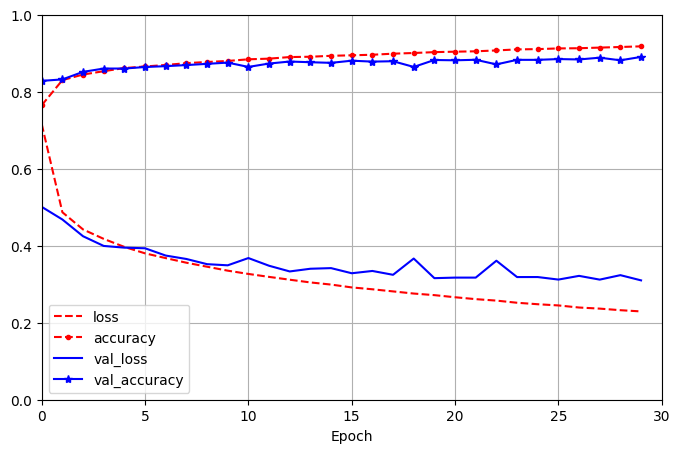

In [30]:
pd.DataFrame(history.history).plot(
  figsize=(8, 5), xlim=[0, 30], ylim=[0, 1], grid=True, xlabel="Epoch",
  style=["r--", "r--.", "b-", "b-*"]
)

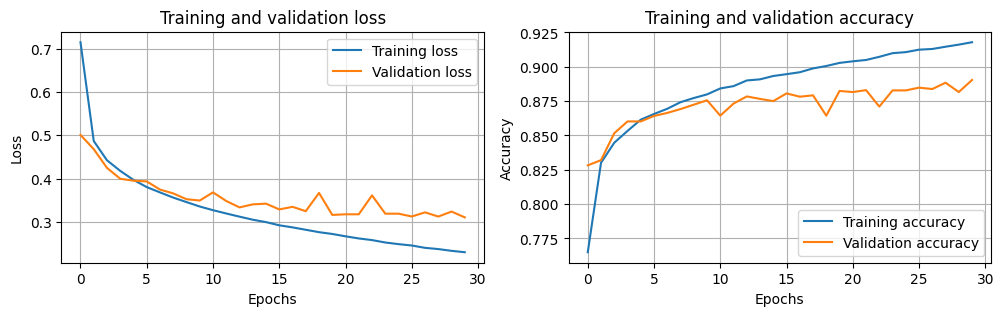

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = history.epoch

fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.sca(axes[1])
plt.plot(epochs, accuracy,  label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()


In [32]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3272 - accuracy: 0.8828


[0.3271940350532532, 0.8827999830245972]

In [33]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 193ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [34]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [35]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [36]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

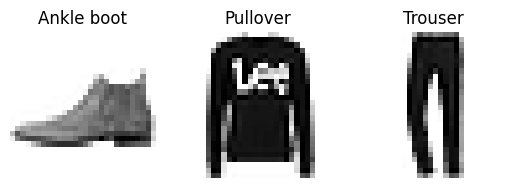

In [40]:
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

### Regression MLP

In [41]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
  housing.data, housing.target, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
  X_train_full, y_train_full, random_state=42
)

In [42]:
tf.random.set_seed(42)
norm_layer = layers.Normalization(input_shape=X_train.shape[1:])

In [125]:
model = keras.Sequential([
  norm_layer,
  layers.Dense(50, activation="relu"),
  layers.Dense(50, activation="relu"),
  layers.Dense(50, activation="relu"),
  layers.Dense(1)
])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 50)                450       
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,618
Trainable params: 5,601
Non-trainable params: 17
___________________________________________________

In [126]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [49]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 0.9383 - root_mean_squared_error: 0.9687 - val_loss: 0.4879 - val_root_mean_squared_error: 0.6985
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3796 - root_mean_squared_error: 0.6161 - val_loss: 1.3562 - val_root_mean_squared_error: 1.1646
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3726 - root_mean_squared_error: 0.6104 - val_loss: 0.3496 - val_root_mean_squared_error: 0.5913
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3400 - root_mean_squared_error: 0.5831 - val_loss: 2.5845 - val_root_mean_squared_error: 1.6076
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3268 - root_mean_squared_error: 0.5717 - val_loss: 2.1206 - val_root_mean_squared_error: 1.4562
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3348 - root_mean_squared_error: 0.5786 - val_loss: 0.4336 - val_

<Axes: xlabel='Epoch'>

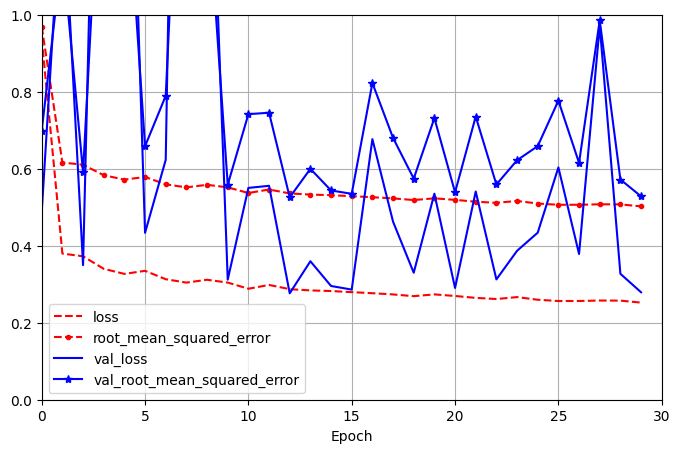

In [50]:
pd.DataFrame(history.history).plot(
  figsize=(8, 5), xlim=[0, 30], ylim=[0, 1], grid=True, xlabel="Epoch",
  style=["r--", "r--.", "b-", "b-*"]
)

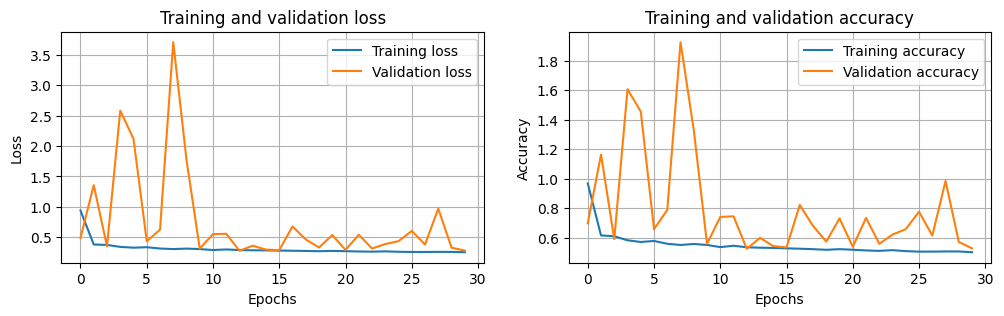

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']

rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

epochs = history.epoch

fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.sca(axes[1])
plt.plot(epochs, rmse,  label='Training accuracy')
plt.plot(epochs, val_rmse, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [54]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.2749 - root_mean_squared_error: 0.5243


[0.27489808201789856, 0.5243072509765625]

In [55]:
X_new = X_test[:3]
X_new

array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02],
       [ 2.53130000e+00,  3.00000000e+01,  5.03938356e+00,
         1.19349315e+00,  1.56500000e+03,  2.67979452e+00,
         3.51400000e+01, -1.19460000e+02],
       [ 3.48010000e+00,  5.20000000e+01,  3.97715472e+00,
         1.18587747e+00,  1.31000000e+03,  1.36033229e+00,
         3.78000000e+01, -1.22440000e+02]])

In [56]:
model.predict(X_new)

1/1 [==============================] - 0s 390ms/step


array([[0.52485424],
       [0.9164789 ],
       [4.7690105 ]], dtype=float32)

In [57]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

### Complex Models using Functional API

In [59]:
normalization_layer = layers.Normalization()
hidden_layer1 = layers.Dense(50, activation="relu")
hidden_layer2 = layers.Dense(50, activation="relu")
hidden_layer3 = layers.Dense(50, activation="relu")
concat_layer = layers.Concatenate()
output_layer = layers.Dense(1)

In [60]:
input_ = layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
hidden3 = hidden_layer3(hidden2)
concat = concat_layer([normalized, hidden3])
output = output_layer(concat)

model = keras.Model(inputs=[input_], outputs=[output])

In [61]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization_1 (Normalization  (None, 8)           17          ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 dense_10 (Dense)               (None, 50)           450         ['normalization_1[0][0]']        
                                                                                                  
 dense_11 (Dense)               (None, 50)           2550        ['dense_10[0][0]']           

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["RootMeanSquaredError"]
)
normalization_layer.adapt(X_train)

In [63]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
363/363 [==============================] - 2s 3ms/step - loss: 1.0071 - root_mean_squared_error: 1.0036 - val_loss: 0.5453 - val_root_mean_squared_error: 0.7384
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3919 - root_mean_squared_error: 0.6260 - val_loss: 0.6100 - val_root_mean_squared_error: 0.7811
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3692 - root_mean_squared_error: 0.6076 - val_loss: 0.5898 - val_root_mean_squared_error: 0.7680
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3396 - root_mean_squared_error: 0.5827 - val_loss: 2.8486 - val_root_mean_squared_error: 1.6878
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3291 - root_mean_squared_error: 0.5737 - val_loss: 1.8266 - val_root_mean_squared_error: 1.3515
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3519 - root_mean_squared_error: 0.5932 - val_loss: 2.6878 - val_

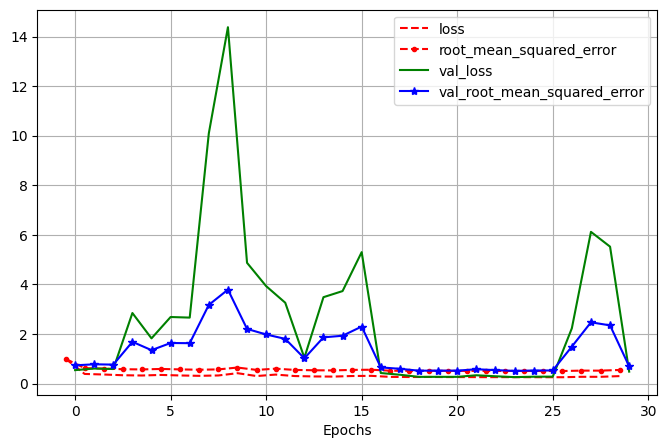

In [64]:
plt.figure(figsize=(8,5))

for key, style in zip(history.history, ["r--", "r--.", "g-", "b-*"]):
  epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
  plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epochs")
plt.grid()
plt.legend()

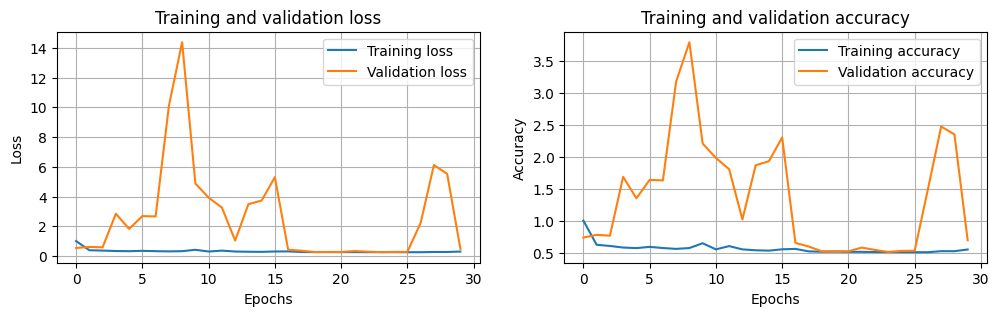

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']

rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

epochs = history.epoch

fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.sca(axes[1])
plt.plot(epochs, rmse,  label='Training accuracy')
plt.plot(epochs, val_rmse, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [66]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.2791 - root_mean_squared_error: 0.5283


[0.2791389524936676, 0.5283360481262207]

In [68]:
model.predict(X_new)

1/1 [==============================] - 0s 216ms/step


array([[0.47576714],
       [1.1505992 ],
       [4.865598  ]], dtype=float32)

In [70]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

### Multiple Inputs

In [71]:
input_wide = layers.Input(shape=[5])
input_deep = layers.Input(shape=[6])

norm_layer_wide = layers.Normalization()
norm_layer_deep = layers.Normalization()

norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)

hidden1 = layers.Dense(50, activation="relu")(norm_deep)
hidden2 = layers.Dense(50, activation="relu")(hidden1)
hidden3 = layers.Dense(50, activation="relu")(hidden2)

concat = layers.concatenate([norm_wide, hidden3])
output = layers.Dense(1)(concat)

model = keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [72]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 normalization_3 (Normalization  (None, 6)           13          ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 dense_14 (Dense)               (None, 50)           350         ['normalization_3[0][0]']        
                                                                                                  
 input_4 (InputLayer)           [(None, 5)]          0           []                         

In [73]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
  loss="mse",
  optimizer=optimizer,
  metrics=["RootMeanSquaredError"]
)

In [74]:
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)

In [75]:
history = model.fit(
  (X_train_wide, X_train_deep), y_train, epochs=30,
  validation_data=((X_valid_wide, X_valid_deep), y_valid)
)

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 1.2891 - root_mean_squared_error: 1.1354 - val_loss: 0.5199 - val_root_mean_squared_error: 0.7210
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4711 - root_mean_squared_error: 0.6863 - val_loss: 2.4160 - val_root_mean_squared_error: 1.5543
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4170 - root_mean_squared_error: 0.6458 - val_loss: 0.3821 - val_root_mean_squared_error: 0.6181
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3704 - root_mean_squared_error: 0.6086 - val_loss: 0.3495 - val_root_mean_squared_error: 0.5912
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3563 - root_mean_squared_error: 0.5969 - val_loss: 0.4779 - val_root_mean_squared_error: 0.6913
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3409 - root_mean_squared_error: 0.5838 - val_loss: 0.3148 - val_

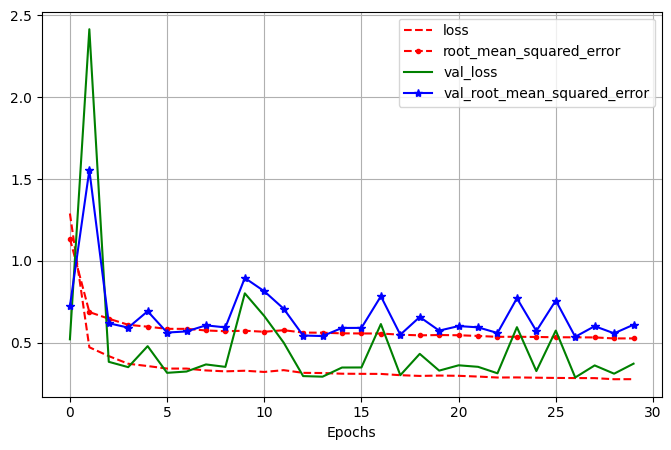

In [76]:
pd.DataFrame(history.history).plot(
  figsize=(8,5), grid=True, xlabel="Epochs",
  style=["r--", "r--.", "g-", "b-*"]
)
plt.legend()


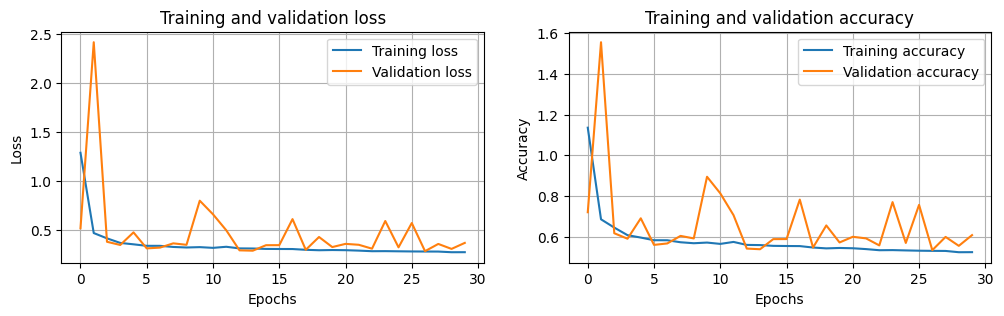

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

epochs = history.epoch

fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.sca(axes[1])
plt.plot(epochs, rmse,  label='Training accuracy')
plt.plot(epochs, val_rmse, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [78]:
model.evaluate((X_test_wide, X_test_deep), y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.2970 - root_mean_squared_error: 0.5450


[0.29704463481903076, 0.5450180172920227]

In [80]:
model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 258ms/step


array([[0.49440524],
       [0.8967973 ],
       [3.7021258 ]], dtype=float32)

In [83]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

### Multiple Inputs and Outputs

In [86]:
input_wide = layers.Input(shape=[5])
norm_layer_wide = layers.Normalization()
norm_wide = norm_layer_wide(input_wide)

input_deep = layers.Input(shape=[6])
norm_layer_deep = layers.Normalization()
norm_deep = norm_layer_deep(input_deep)

hidden1 = layers.Dense(50, activation="relu")(norm_deep)
hidden2 = layers.Dense(50, activation="relu")(hidden1)
hidden3 = layers.Dense(50, activation="relu")(hidden2)

concat = layers.concatenate([norm_wide, hidden3])
output = layers.Dense(1)(concat)

aux_output = layers.Dense(1)(hidden3)

model = keras.Model(inputs=[input_wide, input_deep], outputs=[output, aux_output])

In [87]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 normalization_7 (Normalization  (None, 6)           13          ['input_9[0][0]']                
 )                                                                                                
                                                                                                  
 dense_23 (Dense)               (None, 50)           350         ['normalization_7[0][0]']        
                                                                                                  
 input_8 (InputLayer)           [(None, 5)]          0           []                         

In [88]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=("mse", "mse"),
    loss_weights=(0.9, 0.1),
    optimizer=optimizer,
    metrics=["RootMeanSquaredError"]
)

In [89]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)

history = model.fit(
  (X_train_wide, X_train_deep), (y_train, y_train), epochs=30,
  validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/30
363/363 [==============================] - 3s 5ms/step - loss: 0.9604 - dense_26_loss: 0.9406 - dense_27_loss: 1.1380 - dense_26_root_mean_squared_error: 0.9699 - dense_27_root_mean_squared_error: 1.0668 - val_loss: 0.4632 - val_dense_26_loss: 0.4539 - val_dense_27_loss: 0.5475 - val_dense_26_root_mean_squared_error: 0.6737 - val_dense_27_root_mean_squared_error: 0.7399
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4454 - dense_26_loss: 0.4368 - dense_27_loss: 0.5229 - dense_26_root_mean_squared_error: 0.6609 - dense_27_root_mean_squared_error: 0.7231 - val_loss: 2.3300 - val_dense_26_loss: 2.4682 - val_dense_27_loss: 1.0861 - val_dense_26_root_mean_squared_error: 1.5711 - val_dense_27_root_mean_squared_error: 1.0421
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4168 - dense_26_loss: 0.4092 - dense_27_loss: 0.4850 - dense_26_root_mean_squared_error: 0.6397 - dense_27_root_mean_squared_error: 0.6964 - val_loss: 0.361

In [97]:
history.history.keys()

dict_keys(['loss', 'dense_26_loss', 'dense_27_loss', 'dense_26_root_mean_squared_error', 'dense_27_root_mean_squared_error', 'val_loss', 'val_dense_26_loss', 'val_dense_27_loss', 'val_dense_26_root_mean_squared_error', 'val_dense_27_root_mean_squared_error'])

In [90]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))

162/162 [==============================] - 0s 2ms/step - loss: 0.3074 - dense_26_loss: 0.3020 - dense_27_loss: 0.3552 - dense_26_root_mean_squared_error: 0.5496 - dense_27_root_mean_squared_error: 0.5960


In [91]:
eval_results

[0.30736270546913147,
 0.302049845457077,
 0.35517674684524536,
 0.5495905876159668,
 0.5959670543670654]

In [74]:
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

In [98]:
model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 125ms/step


[array([[0.4935091],
        [1.3135679],
        [3.9424925]], dtype=float32),
 array([[0.6927787],
        [1.2563348],
        [3.8281293]], dtype=float32)]

In [99]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))
y_pred

1/1 [==============================] - 0s 62ms/step


{'dense_26': array([[0.4935091],
        [1.3135679],
        [3.9424925]], dtype=float32),
 'dense_27': array([[0.6927787],
        [1.2563348],
        [3.8281293]], dtype=float32)}

In [100]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

### Subclassing API to Build Dynamic Models

In [101]:
class WideAndDeepModel(keras.Model):
  def __init__(self, units=50, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.norm_layer_wide = layers.Normalization()
    self.norm_layer_deep = layers.Normalization()
    self.hidden1 = layers.Dense(units, activation=activation)
    self.hidden2 = layers.Dense(units, activation=activation)
    self.hidden3 = layers.Dense(units, activation=activation)
    self.main_output = layers.Dense(1)
    self.aux_output = layers.Dense(1)

  def call(self, inputs):
    input_wide, input_deep = inputs
    norm_wide = self.norm_layer_wide(input_wide)
    norm_deep = self.norm_layer_deep(input_deep)
    hidden1 = self.hidden1(norm_deep)
    hidden2 = self.hidden2(hidden1)
    hidden3 = self.hidden3(hidden2)
    concat = layers.concatenate([norm_wide, hidden2])
    output = self.main_output(concat)
    aux_output = self.aux_output(hidden3)

    return output, aux_output

model = WideAndDeepModel(50, activation="relu", name="my_model")

In [102]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)

model.compile(
    loss=("mse", "mse"),
    loss_weights=(0.9, 0.1),
    optimizer=optimizer,
    metrics=["RootMeanSquaredError"]
)

In [103]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)

history = model.fit(
  (X_train_wide, X_train_deep), (y_train, y_train), epochs=30,
  validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/30
363/363 [==============================] - 3s 4ms/step - loss: 1939.0485 - output_1_loss: 2148.4351 - output_2_loss: 54.5651 - output_1_root_mean_squared_error: 46.3512 - output_2_root_mean_squared_error: 7.3868 - val_loss: 16.6078 - val_output_1_loss: 17.5356 - val_output_2_loss: 8.2575 - val_output_1_root_mean_squared_error: 4.1876 - val_output_2_root_mean_squared_error: 2.8736
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 11.5280 - output_1_loss: 10.3402 - output_2_loss: 22.2180 - output_1_root_mean_squared_error: 3.2156 - output_2_root_mean_squared_error: 4.7136 - val_loss: 8.5588 - val_output_1_loss: 9.2686 - val_output_2_loss: 2.1700 - val_output_1_root_mean_squared_error: 3.0444 - val_output_2_root_mean_squared_error: 1.4731
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 20.2351 - output_1_loss: 7.3559 - output_2_loss: 136.1484 - output_1_root_mean_squared_error: 2.7122 - output_2_root_mean_squared_error: 11.6683 

In [104]:
model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))

162/162 [==============================] - 0s 2ms/step - loss: 0.7496 - output_1_loss: 0.6630 - output_2_loss: 1.5293 - output_1_root_mean_squared_error: 0.8142 - output_2_root_mean_squared_error: 1.2367


[0.7496021389961243,
 0.6629689931869507,
 1.5293034315109253,
 0.8142290711402893,
 1.2366501092910767]

In [106]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  multiple                 11        
 ion)                                                            
                                                                 
 normalization_9 (Normalizat  multiple                 13        
 ion)                                                            
                                                                 
 dense_28 (Dense)            multiple                  350       
                                                                 
 dense_29 (Dense)            multiple                  2550      
                                                                 
 dense_30 (Dense)            multiple                  2550      
                                                                 
 dense_31 (Dense)            multiple                  56 

In [108]:
model.save("Models/my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: Models/my_keras_model\assets


In [109]:
model = keras.models.load_model("Models/my_keras_model")
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  multiple                 11        
 ion)                                                            
                                                                 
 normalization_9 (Normalizat  multiple                 13        
 ion)                                                            
                                                                 
 dense_28 (Dense)            multiple                  350       
                                                                 
 dense_29 (Dense)            multiple                  2550      
                                                                 
 dense_30 (Dense)            multiple                  2550      
                                                                 
 dense_31 (Dense)            multiple                  56 

In [110]:
model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 273ms/step


(array([[1.1949869],
        [1.727614 ],
        [2.6137319]], dtype=float32),
 array([[1.7164558],
        [1.663833 ],
        [1.8066581]], dtype=float32))

### Using Callbacks

In [113]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("Models/my_checkpoints", save_weights_only=True)

history = model.fit(
  (X_train_wide, X_train_deep), (y_train, y_train), epochs=30,
  validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
  callbacks=[checkpoint_cb]
)

Epoch 1/30
363/363 [==============================] - 2s 5ms/step - loss: 0.9128 - output_1_loss: 0.8635 - output_2_loss: 1.3566 - output_1_root_mean_squared_error: 0.9292 - output_2_root_mean_squared_error: 1.1647 - val_loss: 0.6783 - val_output_1_loss: 0.6181 - val_output_2_loss: 1.2202 - val_output_1_root_mean_squared_error: 0.7862 - val_output_2_root_mean_squared_error: 1.1046
Epoch 2/30
363/363 [==============================] - 1s 4ms/step - loss: 1.0272 - output_1_loss: 0.9913 - output_2_loss: 1.3501 - output_1_root_mean_squared_error: 0.9956 - output_2_root_mean_squared_error: 1.1619 - val_loss: 0.7578 - val_output_1_loss: 0.6907 - val_output_2_loss: 1.3620 - val_output_1_root_mean_squared_error: 0.8311 - val_output_2_root_mean_squared_error: 1.1670
Epoch 3/30
363/363 [==============================] - 1s 4ms/step - loss: 0.8041 - output_1_loss: 0.7499 - output_2_loss: 1.2925 - output_1_root_mean_squared_error: 0.8659 - output_2_root_mean_squared_error: 1.1369 - val_loss: 0.944

In [114]:
early_stopping_cb = keras.callbacks.EarlyStopping(
  patience=5, restore_best_weights=True
)

In [116]:
history = model.fit(
  (X_train_wide, X_train_deep), (y_train, y_train), epochs=30,
  validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
  callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/30
363/363 [==============================] - 1s 4ms/step - loss: 0.7643 - output_1_loss: 0.7005 - output_2_loss: 1.3386 - output_1_root_mean_squared_error: 0.8370 - output_2_root_mean_squared_error: 1.1570 - val_loss: 2.7320 - val_output_1_loss: 2.6177 - val_output_2_loss: 3.7599 - val_output_1_root_mean_squared_error: 1.6179 - val_output_2_root_mean_squared_error: 1.9390
Epoch 2/30
363/363 [==============================] - 2s 4ms/step - loss: 0.8977 - output_1_loss: 0.8485 - output_2_loss: 1.3411 - output_1_root_mean_squared_error: 0.9211 - output_2_root_mean_squared_error: 1.1581 - val_loss: 1.1102 - val_output_1_loss: 0.9323 - val_output_2_loss: 2.7114 - val_output_1_root_mean_squared_error: 0.9655 - val_output_2_root_mean_squared_error: 1.6466
Epoch 3/30
363/363 [==============================] - 2s 4ms/step - loss: 0.8746 - output_1_loss: 0.8225 - output_2_loss: 1.3436 - output_1_root_mean_squared_error: 0.9069 - output_2_root_mean_squared_error: 1.1591 - val_loss: 0.694

In [164]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    ratio = logs["val_loss"] / logs["loss"]
    print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [166]:
history = model.fit(
    X_train, y_train, epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks = [PrintValTrainRatioCallback()],
    verbose=0
)

Epoch=0, val/train=2.32
Epoch=1, val/train=2.61
Epoch=2, val/train=2.14
Epoch=3, val/train=2.07
Epoch=4, val/train=2.23
Epoch=5, val/train=2.16
Epoch=6, val/train=2.23
Epoch=7, val/train=2.30
Epoch=8, val/train=2.11
Epoch=9, val/train=2.13
Epoch=10, val/train=2.47
Epoch=11, val/train=2.65
Epoch=12, val/train=2.32
Epoch=13, val/train=2.41
Epoch=14, val/train=2.14
Epoch=15, val/train=2.16
Epoch=16, val/train=2.24
Epoch=17, val/train=2.16
Epoch=18, val/train=2.18
Epoch=19, val/train=2.17
Epoch=20, val/train=2.40
Epoch=21, val/train=2.24
Epoch=22, val/train=2.27
Epoch=23, val/train=2.31
Epoch=24, val/train=2.17
Epoch=25, val/train=2.35
Epoch=26, val/train=2.26
Epoch=27, val/train=2.20
Epoch=28, val/train=2.28
Epoch=29, val/train=2.30


### Tensorflow Board

In [150]:
def get_run_logdir(root_logdir="my_logs"):
  return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [158]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["RootMeanSquaredError"]
)

In [159]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, profile_batch=(100,200))

history = model.fit(
    X_train, y_train, epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks = [tensorboard_cb]
)

Epoch 1/30
363/363 [==============================] - 3s 6ms/step - loss: 0.1408 - root_mean_squared_error: 0.3752 - val_loss: 0.6338 - val_root_mean_squared_error: 0.7961
Epoch 2/30
363/363 [==============================] - 1s 4ms/step - loss: 0.1434 - root_mean_squared_error: 0.3787 - val_loss: 0.2786 - val_root_mean_squared_error: 0.5278
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.1406 - root_mean_squared_error: 0.3749 - val_loss: 0.2811 - val_root_mean_squared_error: 0.5302
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.1412 - root_mean_squared_error: 0.3758 - val_loss: 0.2685 - val_root_mean_squared_error: 0.5181
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.1399 - root_mean_squared_error: 0.3740 - val_loss: 0.2781 - val_root_mean_squared_error: 0.5274
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.1402 - root_mean_squared_error: 0.3744 - val_loss: 0.2857 - val_

In [161]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2025_02_22_17_07_50
    events.out.tfevents.1740240596.INFINITY.profile-empty
    plugins
      profile
        2025_02_22_16_09_56
          INFINITY.input_pipeline.pb
          INFINITY.kernel_stats.pb
          INFINITY.memory_profile.json.gz
          INFINITY.overview_page.pb
          INFINITY.tensorflow_stats.pb
          INFINITY.trace.json.gz
          INFINITY.xplane.pb
        2025_02_22_16_11_04
          INFINITY.input_pipeline.pb
          INFINITY.kernel_stats.pb
          INFINITY.memory_profile.json.gz
          INFINITY.overview_page.pb
          INFINITY.tensorflow_stats.pb
          INFINITY.trace.json.gz
          INFINITY.xplane.pb
    train
      events.out.tfevents.1740240595.INFINITY.12220.0.v2
      events.out.tfevents.1740240663.INFINITY.12220.2.v2
    validation
      events.out.tfevents.1740240597.INFINITY.12220.1.v2
      events.out.tfevents.1740240664.INFINITY.12220.3.v2
  run_2025_02_22_17_14_56
    events.out.tfevents.1740240914.INFINITY.p

In [162]:
%load_ext tensorboard

In [163]:
%tensorboard --logdir=./my_logs

In [167]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

In [8]:
def build_model(hp):
  n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
  n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
  learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
  optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
  if optimizer == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten())
  for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  return model

In [9]:
random_search_tuner = kt.RandomSearch(
  build_model, objective="val_accuracy", max_trials=5, overwrite=True,
  directory="my_fashion_mnist", project_name="my_rnd_search", seed=42
)

random_search_tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 52s]
val_accuracy: 0.7268000245094299

Best val_accuracy So Far: 0.8596000075340271
Total elapsed time: 00h 04m 35s


In [11]:
top3_models = random_search_tuner.get_best_models(num_models=3)
top3_models

In [17]:
best_model = top3_models[0]
best_model

In [15]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 8,
 'n_neurons': 37,
 'learning_rate': 0.008547485565344062,
 'optimizer': 'sgd'}

In [18]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 3 summary
Hyperparameters:
n_hidden: 8
n_neurons: 37
learning_rate: 0.008547485565344062
optimizer: sgd
Score: 0.8596000075340271


In [19]:
best_trial.metrics.get_last_value("val_accuracy")

0.8596000075340271

In [20]:
best_model.fit(X_train_full, y_train_full, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.1003
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: nan - accuracy: 0.1000
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1000


In [21]:
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.1000


[nan, 0.10000000149011612]

In [25]:
class MyClassificationHyperModel(kt.HyperModel):
  def build(self, hp):
    return build_model(hp)

  def fit(self, hp, model, X, y, **kwargs):
    if hp.Boolean("normalize"):
      norm_layer = tf.keras.layers.Normalization()
      X = norm_layer(X)
    return model.fit(X, y, **kwargs)

In [26]:
hyperband_tuner = kt.Hyperband(
  MyClassificationHyperModel(), objective="val_accuracy", seed=42,
  max_epochs=10, factor=3, hyperband_iterations=2, overwrite=True,
  directory="my_fashion_mnist", project_name="hyperband"
)